In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
random.seed(13)
from tqdm.auto import tqdm

import rdkit
print(rdkit.__version__)
from rdkit import Chem
from rdkit.Chem import AllChem 
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
from rdkit.ML.Scoring.Scoring import CalcBEDROC
import joblib

import sklearn
from sklearn.ensemble import RandomForestClassifier

print(sklearn.__version__)

from imblearn.over_sampling import SMOTE, SMOTENC

2023.03.3
1.4.0


In [47]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
# Function to calculate TPR at specific FPR (e.g., 1%)
def tpr_at_fpr(fpr_array, tpr_array, target_fpr=0.01):
    interp_tpr = interp1d(fpr_array, tpr_array)
    return interp_tpr(target_fpr)

In [2]:
subset1 = pd.read_csv('./datasets/3_train_test_split/pubchem_trainset_featurized.csv')
subset2 = pd.read_csv('./datasets/3_train_test_split/pubchem_testset_featurized.csv')

In [3]:
print(len(subset1), len(subset2))

1946 487


## prepare similarity based splitting for cross validation

In [4]:
#meeded in cluter with butina function
def tanimoto_distance_matrix(fp_list):
    """
    Calculate distance matrix for fingerprint list.
    Copy pasted form Reference (see top of the notebook).
    """
    dissimilarity_matrix = []
    for i in tqdm(range(1, len(fp_list))):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [5]:
#cluster with butina

def cluster_fingerprints(fp_list, cutoff=0.7):
    """
    Cluster fingerprints using Butina:
    given the input distance matrix cluster together all the
    molecules with a distance <= cutoff.
    e.g.: if cutoff == 0.3 the molecules with tanimoto >= 0.7
    will be clustered together.

    Returns a list of tuples where each tuple is a cluster
    and each value in the tuple correspond to the fingerprint
    index in the fingerprints list.

    Copy pasted from the Reference (see top of the notebook)
    """
    # Calculate Tanimoto distance matrix
    print("Computing distance matrix . . .")
    distance_matrix = tanimoto_distance_matrix(fp_list)
    # Cluster the data with the implemented Butina algorithm.
    print("Computing clusters . . .")
    clusters = Butina.ClusterData(distance_matrix, len(fp_list), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True) # Sort the list of clusters in descending order.
    print("Clusters computed!")
    return clusters

In [6]:
smiles = subset1['preprocessedSmiles']
# Get only the values from the series.
smiles_array = smiles.values


In [7]:
smiles_array

array(['I.I.NCCN', 'C=CCN1CCC23c4c5ccc(O)c4OC2C(=O)CCC3(O)C1C5',
       'CCCCS(=O)(=O)NC(Cc1ccc(OCCCCC2CCNCC2)cc1)C(=O)O', ...,
       'CCCCCCC(=O)CCCCCCC=CCC(O)C(O)C(N)(CO)C(=O)O',
       'CON=C(C(=O)NC1C(=O)N2C(C(=O)O)=CCSC12)c1csc(N)n1',
       'O=C(O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)cc2c1=O'], dtype=object)

In [8]:
print("# of unique smiles:", len(smiles_array))
fingerprints_list = []
for smi in tqdm(smiles):
    mol = Chem.MolFromSmiles(smi) # get mol object
    fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    fingerprints_list.append(fps)


# of unique smiles: 1946


  0%|          | 0/1946 [00:00<?, ?it/s]

In [9]:
clusters = cluster_fingerprints(fingerprints_list)

Computing distance matrix . . .


  0%|          | 0/1945 [00:00<?, ?it/s]

Computing clusters . . .
Clusters computed!


In [10]:
len(clusters)

670

In [11]:
# Specify parameters
folds = 5 # number of splits you need

In [12]:
def cross_validation_splits(smiles, clusters, folds):
    """
    Group smiles strings into n = folds datasets.
    """
    # Number of compounds you want in each split.
    # Assume cv split so same number of compounds for each splits.
    splits_size = np.floor(len(smiles)/folds)
    
    random.shuffle(clusters) # shuffle the clusters

    splits = {key: [] for key in range(folds)}
    key = 0
    for clu in tqdm(clusters):
        # Check that the lenght of the split does not exceed the lenght of the split.
        # This ensure that all the splits will have almost the same lenght.
        if len(splits[key]) <= splits_size:
            splits[key] += list(smiles[list(clu)])
        # If not go to the next split.
        else:
            key += 1
            splits[key] += list(smiles[list(clu)])
    return splits

In [13]:
splits = cross_validation_splits(smiles_array, clusters, folds)

  0%|          | 0/670 [00:00<?, ?it/s]

In [14]:
type(splits)

dict

In [15]:
print(type(splits[0]))

<class 'list'>


In [16]:
type(splits[0][1])

str

In [17]:
len(splits)

5

In [18]:
# Print the lenght of each split.
for idx, val in splits.items():
    print(f"len fold {idx} :", len(val))

len fold 0 : 390
len fold 1 : 390
len fold 2 : 390
len fold 3 : 390
len fold 4 : 386


In [19]:
print(splits.items())

dict_items([(0, ['CCOP(=O)(OCC)Oc1ccc([N+](=O)[O-])cc1', 'COP(=S)(OC)Oc1ccc([N+](=O)[O-])cc1Cl', 'CC(C)CCCCCCCOP(=O)(Oc1ccccc1)Oc1ccccc1', 'O=C(Nc1ccc([N+](=O)[O-])cc1)Nc1ccc([N+](=O)[O-])cc1', 'CCOP(=O)(NC(C)C)Oc1ccc(SC)c(C)c1', 'O=[N+]([O-])c1ccc(Oc2ccc([N+](=O)[O-])cc2)cc1', 'O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1', 'COP(=S)(OC)Oc1ccc([N+](=O)[O-])cc1', 'CC(C)c1ccc(OP(=O)(Oc2ccc(C(C)C)cc2)Oc2ccc(C(C)C)cc2)cc1', 'CC(C)(C)c1ccc(OP(=O)(Oc2ccccc2)Oc2ccccc2)cc1', 'Cc1c(Cl)c(=O)oc2cc(OP(=O)(OCCCl)OCCCl)ccc12', 'O=[N+]([O-])c1ccc(Oc2ccc(N=C=S)cc2)cc1', 'CCOP(=O)(CC)Oc1ccc([N+](=O)[O-])cc1', 'CCOP(=O)(Sc1ccccc1)Sc1ccccc1', 'CCOP(=S)(OCC)Oc1ccc([S+](C)[O-])cc1', 'Cc1ccc(OP(=O)(Oc2ccccc2)Oc2ccccc2)cc1', 'CCOP(=S)(Oc1ccc([N+](=O)[O-])cc1)c1ccccc1', 'CCCSP(=S)(OCC)Oc1ccc(SC)cc1', 'CCOP(=O)(OCC)Oc1cc(C)nc(C(C)C)n1', 'COP(=S)(OC)Oc1ccc([N+](=O)[O-])c(C)c1', 'CCOP(=O)(OCC)Oc1nc(Cl)c(Cl)cc1Cl', 'CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1', 'O=P(Cl)(Oc1ccccc1)Oc1ccccc1', 'O=[PH](=O)(Oc1ccccc1)Oc1ccccc1', 'Cc1

In [20]:
def map_func(x):
    for k, v in splits.items():
        if x in v:
            return str(k)


# Create a new column in the dataframe and apply the mapping function to the existing_col column
subset1['cluster_id'] = subset1['preprocessedSmiles'].apply(map_func)
subset1

,index,preprocessedSmiles,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,Molecule,descriptor,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,morgan2_b2039,morgan2_b2040,morgan2_b2041,morgan2_b2042,morgan2_b2043,morgan2_b2044,morgan2_b2045,morgan2_b2046,morgan2_b2047,cluster_id
0,7345,I.I.NCCN,144212583.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[4.902777777777778, 0.0, 4.902777777777778, 0....",4.902778,0.000000,4.902778,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2449,C=CCN1CCC23c4c5ccc(O)c4OC2C(=O)CCC3(O)C1C5,144205559.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[12.63331640526581, -1.0011111111111108, 12.63...",12.633316,-1.001111,12.633316,0.040783,...,0,0,0,0,0,0,0,0,0,0
2,3256,CCCCS(=O)(=O)NC(Cc1ccc(OCCCCC2CCNCC2)cc1)C(=O)O,144206533.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[12.023544214209608, -3.601087932491708, 12.02...",12.023544,-3.601088,12.023544,0.057844,...,0,0,0,0,0,0,0,0,0,0
3,629,CC1(C)NC(=O)N(c2ccc([N+](=O)[O-])c(C(F)(F)F)c2...,144203764.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[12.913567058767953, -4.992877692743764, 12.91...",12.913567,-4.992878,12.913567,0.383333,...,0,0,0,0,0,0,0,0,0,2
4,2129,O=C(OCC1OC(O)(COC(=O)c2cccnc2)C(OC(=O)c2cccnc2...,144205184.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[13.119448112645784, -2.568453247039556, 13.11...",13.119448,-2.568453,13.119448,0.005552,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,3478,COc1ccc(CNCC(O)COc2ccc3[nH]c(=O)ccc3c2)cc1OC,144206841.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[11.31411572173414, -0.6607211619215594, 11.31...",11.314116,-0.660721,11.314116,0.141532,...,0,0,0,0,0,0,0,0,0,3
1942,2443,COc1cc2c(cc1OC)C(C(C(=O)N(CCc1ccc(OC)c(OC)c1OC...,144205546.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[15.26630536862995, -0.696343410310764, 15.266...",15.266305,-0.696343,15.266305,0.091230,...,0,0,0,0,0,0,0,0,0,2
1943,2496,CCCCCCC(=O)CCCCCCC=CCC(O)C(O)C(N)(CO)C(=O)O,144205615.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[11.716878688144716, -2.2770913731098577, 11.7...",11.716879,-2.277091,11.716879,0.055486,...,0,0,1,0,0,0,0,0,0,0
1944,2860,CON=C(C(=O)NC1C(=O)N2C(C(=O)O)=CCSC12)c1csc(N)n1,144206017.0,Inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[12.472505826404635, -1.1777690626806787, 12.4...",12.472506,-1.177769,12.472506,0.071939,...,0,0,0,0,0,0,0,0,0,4


## RDKit 2D models

### cross validation

In [21]:
from sklearn.model_selection import GroupKFold
groups = np.array(subset1['cluster_id'])

In [22]:
def roc_cv(X,y):
    cv = GroupKFold(n_splits=5)
    classifier = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features=max_features, 
                                        min_samples_split=2, random_state=42)
                                        #max_features and min_samples_split are actually equal to default
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    BEDROC = []

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
        classifier.fit(X[train], y[train])
        y_prob = classifier.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        
        score = list(zip(y_prob, y[test]))
        score.sort(key=lambda x: x[0], reverse=True)
        bedroc_score = CalcBEDROC(score, 1, 80.5)
        BEDROC.append(bedroc_score)

   
    print(BEDROC)
    mean_bedroc = np.mean(BEDROC)
    std_bedroc = np.std(BEDROC)
    print("BEDROC: {:.3f} +/- {:.3f}".format(mean_bedroc, std_bedroc))

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()


In [23]:
desc_cols = subset1.iloc[:, 6:214] 

In [24]:
desc_cols

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.902778,0.000000,4.902778,0.000000,0.676405,315.924,305.844,315.893344,42,0,...,0,0,0,0,0,0,0,0,0,0
1,12.633316,-1.001111,12.633316,0.040783,0.801520,327.380,306.212,327.147058,126,0,...,0,0,0,0,0,0,0,0,0,0
2,12.023544,-3.601088,12.023544,0.057844,0.384302,440.606,404.318,440.234493,170,0,...,0,1,0,0,0,0,0,0,2,0
3,12.913567,-4.992878,12.913567,0.383333,0.514937,317.223,307.143,317.062340,118,0,...,0,0,0,0,0,0,0,0,0,1
4,13.119448,-2.568453,13.119448,0.005552,0.205086,600.540,576.348,600.149243,224,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,11.314116,-0.660721,11.314116,0.141532,0.523094,384.432,360.240,384.168522,148,0,...,0,0,0,0,0,0,0,0,0,0
1942,15.266305,-0.696343,15.266305,0.091230,0.126610,712.840,664.456,712.335981,276,0,...,0,0,0,0,0,0,0,0,0,0
1943,11.716879,-2.277091,11.716879,0.055486,0.175204,401.544,362.232,401.277738,164,0,...,0,0,0,0,0,0,0,0,6,0
1944,12.472506,-1.177769,12.472506,0.071939,0.348318,383.411,370.307,383.035811,132,0,...,1,0,0,0,0,1,0,0,0,0


In [25]:
X = np.array(desc_cols)
y = np.array(subset1.y_ture_lable)

[0.8320892765911359, 0.6844479305569044, 0.4815823915710592, 0.7885978264238028, 0.614450425824814]
BEDROC: 0.680 +/- 0.125


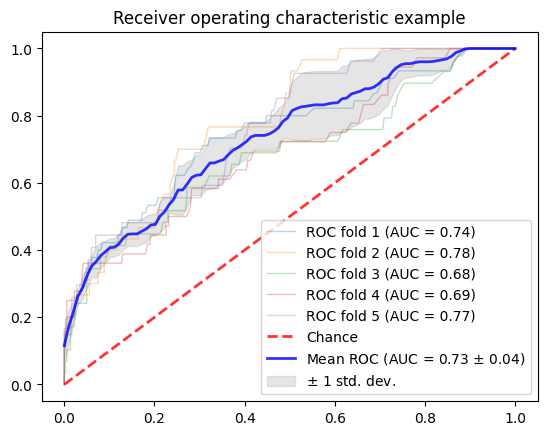

[0.8977483910754457, 0.7163038891118815, 0.5495853918446526, 0.8474304842590394, 0.626716648764395]
BEDROC: 0.728 +/- 0.131


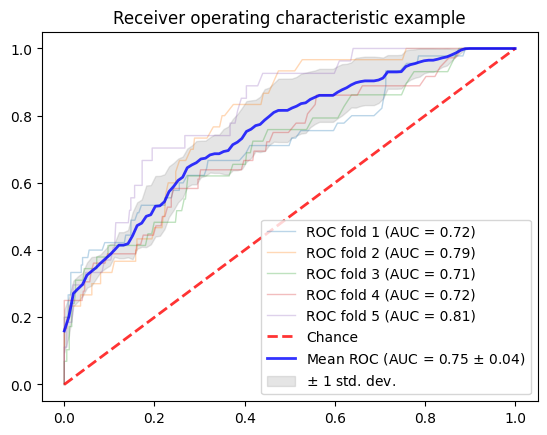

[0.8578990030915089, 0.7227803903569259, 0.5182694826677796, 0.8466635234756655, 0.6105589923204013]
BEDROC: 0.711 +/- 0.132


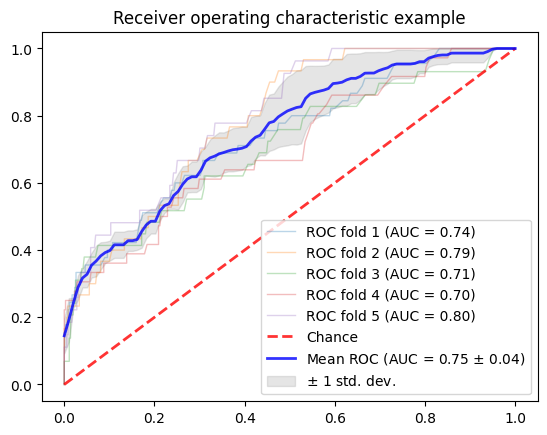

[0.8601745373767271, 0.710968614929402, 0.5314777917954845, 0.8420050636967691, 0.6152596127276646]
BEDROC: 0.712 +/- 0.127


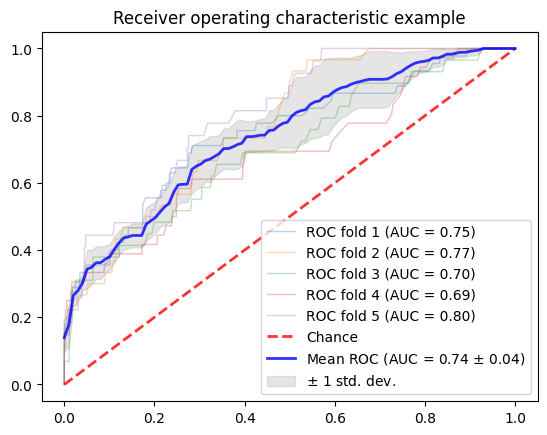

[0.8553579393284677, 0.6894967935205399, 0.46948564964957745, 0.7929019305565618, 0.5879709898762983]
BEDROC: 0.679 +/- 0.139


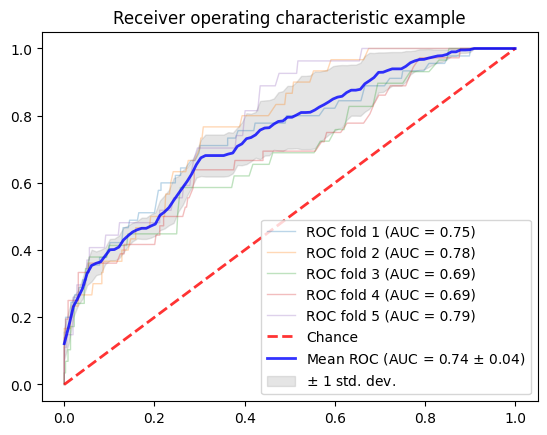

In [26]:
max_features_list = [None, 'sqrt', 0.2, 0.4, 0.8]
for max_features in max_features_list:
    roc_cv(X,y)

### combine the folds and train with best hyperparameter

In [27]:
#80% model, with max_features=sqrt as the best hyperparamter
X = np.array(desc_cols)
y = np.array(subset1.y_ture_lable)
sm = SMOTE(random_state = 42)
X, y = sm.fit_resample(X,y)
model_0 = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features='sqrt', 
                                        min_samples_split=2, random_state=42).fit(X, y)

In [30]:
# test with 20% test set
desc_cols2 = subset2.iloc[:, 6:214]
X = np.array(desc_cols2)
y = subset2.y_ture_lable

BEDROC: 0.773


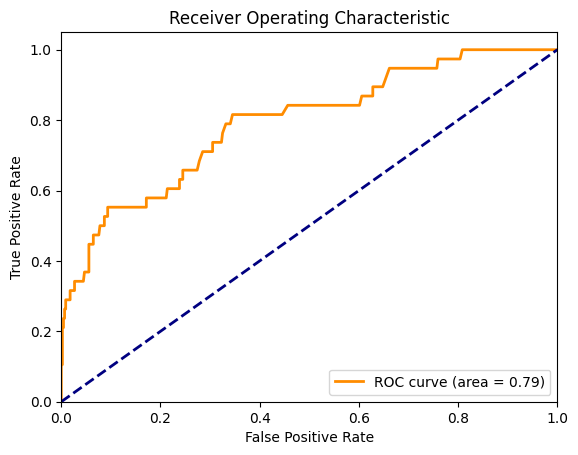

In [31]:
# Predict probabilities for the test data
y_scores = model_0.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [73]:
# combine train and test set and train the final model with full dataset
fullset = pd.concat([subset1, subset2], ignore_index=True)
desc_cols3 = fullset.iloc[:, 6:214]
X = np.array(desc_cols3)
y = fullset.y_ture_lable

sm = SMOTE(random_state = 42)
X, y = sm.fit_resample(X,y)

In [74]:
combined_model = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features='sqrt', 
                                        min_samples_split=2, random_state=42).fit(X, y)
joblib.dump(combined_model, f'./pretrained_models/pubchem_rdkit2D_maxfeatures_sqrt_fullset.joblib')

['/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/pretrained_models/pubchem_rdkit2D_maxfeatures_sqrt_fullset.joblib']

## ECFP4 models

### cross validation

In [37]:
morgan2_cols = ['morgan2_b'+str(i) for i in list(range(2048))]
X = subset1[morgan2_cols]
y = subset1.y_ture_lable

[0.9132919042840223, 0.6453452065274887, 0.24809113630025864, 0.7672078486082003, 0.6794164925430801]
BEDROC: 0.651 +/- 0.222


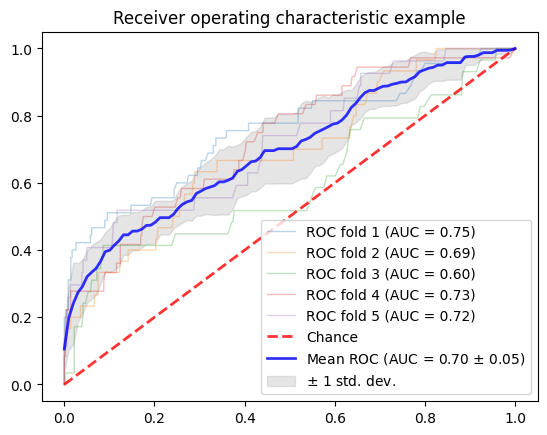

[0.951479850265471, 0.6196136424062776, 0.5759192501276348, 0.7385748469882775, 0.6929545286003315]
BEDROC: 0.716 +/- 0.131


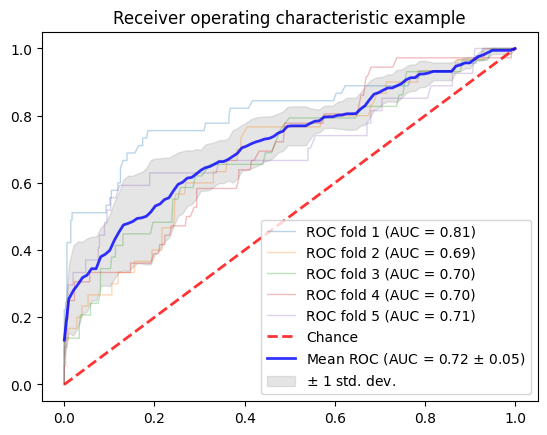

[0.9348629627046979, 0.6557163128725723, 0.28846885214460594, 0.7394412293468223, 0.6940402647833174]
BEDROC: 0.663 +/- 0.210


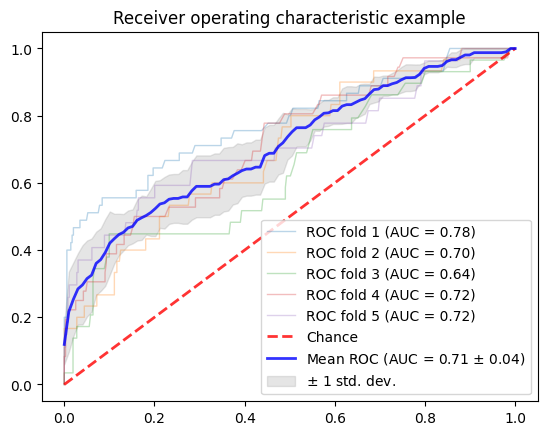

[0.9444053396334678, 0.6304208252059725, 0.27908003294106515, 0.7521915633040904, 0.7026989704703012]
BEDROC: 0.662 +/- 0.218


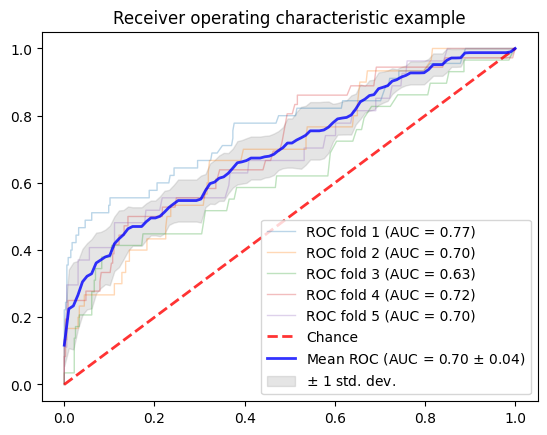

[0.9245534963756559, 0.6344434016433308, 0.42286562205589656, 0.7702339012323529, 0.6482019705669747]
BEDROC: 0.680 +/- 0.166


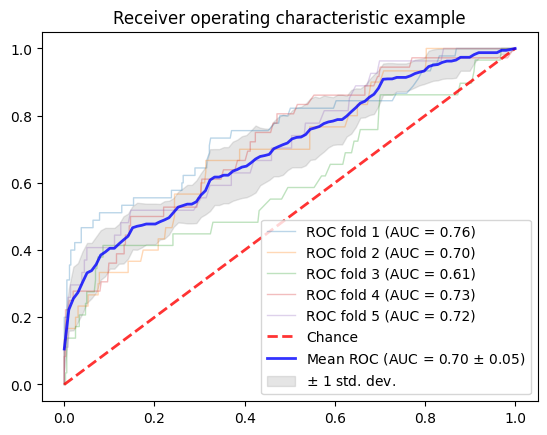

In [38]:
max_features_list = [None, 'sqrt', 0.2, 0.4, 0.8]
for max_features in max_features_list:
    roc_cv(np.array(X),np.array(y))

### combine the folds and train with best hyperparameter

In [40]:
#80% model, with max_features=sqrt as the best hyperparamter
X = subset1[morgan2_cols]
y = subset1.y_ture_lable
sm = SMOTENC(categorical_features=[0,1],random_state = 42) 
X, y = sm.fit_resample(X,y)
model_1 = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features='sqrt', 
                                        min_samples_split=2, random_state=42).fit(np.array(X),np.array(y))

In [41]:
#test with 20% test set
X = np.array(subset2[morgan2_cols])
y = subset2.y_ture_lable

[(0.998, 1.0), (0.998, 1.0), (0.984, 1.0), (0.964, 1.0), (0.928, 0.0), (0.879, 1.0), (0.87, 1.0), (0.78, 0.0), (0.771, 0.0), (0.678, 0.0), (0.677, 1.0), (0.657, 1.0), (0.6565, 1.0), (0.649, 0.0), (0.645, 0.0), (0.611, 0.0), (0.609, 1.0), (0.601, 0.0), (0.583, 0.0), (0.561, 1.0), (0.557, 0.0), (0.556, 0.0), (0.553, 0.0), (0.522, 0.0), (0.518, 0.0), (0.513, 0.0), (0.51, 0.0), (0.504, 0.0), (0.503, 0.0), (0.5, 0.0), (0.495, 0.0), (0.493, 0.0), (0.492, 0.0), (0.49, 0.0), (0.48, 1.0), (0.459, 0.0), (0.449, 0.0), (0.438, 0.0), (0.432, 1.0), (0.432, 0.0), (0.428, 0.0), (0.417, 1.0), (0.409, 0.0), (0.394, 0.0), (0.393, 0.0), (0.381, 0.0), (0.377, 0.0), (0.373, 0.0), (0.372, 1.0), (0.361, 1.0), (0.358, 0.0), (0.358, 1.0), (0.349, 0.0), (0.339, 0.0), (0.3365666666666667, 0.0), (0.333, 0.0), (0.333, 1.0), (0.319, 0.0), (0.319, 0.0), (0.312, 0.0), (0.3118, 0.0), (0.305, 0.0), (0.304, 0.0), (0.29966666666666664, 0.0), (0.2993333333333334, 0.0), (0.298, 0.0), (0.291, 0.0), (0.29, 0.0), (0.288, 0.0),

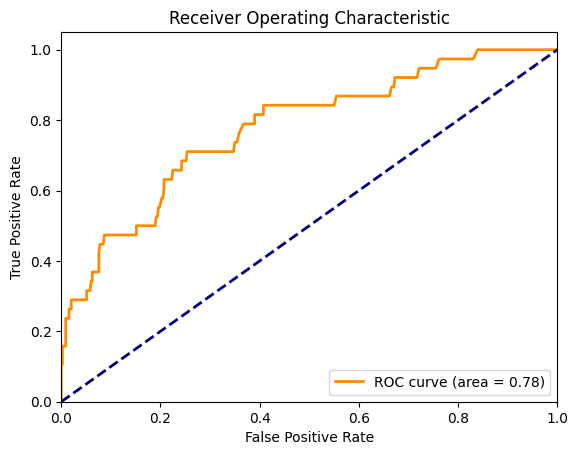

In [42]:
# Predict probabilities for the test data
y_scores = model_1.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
print(score)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [43]:
# combine train and test set and train the final model with full dataset
X = fullset[morgan2_cols]
y = fullset.y_ture_lable
sm = SMOTENC(categorical_features=[0,1],random_state = 42) 
X, y = sm.fit_resample(X,y)

combined_model = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features='sqrt', 
                                        min_samples_split=2, random_state=42).fit(np.array(X),np.array(y))
joblib.dump(combined_model, f'./pretrained_models/pubchem_morgan2_maxfeatures_sqrt_fullset.joblib')

['/home/sliu/cyp_related_coding/CYP19_inhibitor_screening/pretrained_models/pubchem_morgan2_maxfeatures_sqrt_fullset.joblib']

## plot for tow models together

In [50]:

# plot the roc curve of the 20% pubchem test set on the two models trained with 80% training set
X = np.array(desc_cols2)
y = subset2.y_ture_lable

# Predict probabilities for the test data with Model 1
y_scores_model_1 = model_0.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_1, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score1 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y, y_scores_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

X = np.array(subset2[morgan2_cols])
y = subset2.y_ture_lable


# Predict probabilities for the test data with Model 2
y_scores_model_2 = model_1.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_2, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score2 = CalcBEDROC(score, 1, 80.5)


# Compute ROC metrics for Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y, y_scores_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)


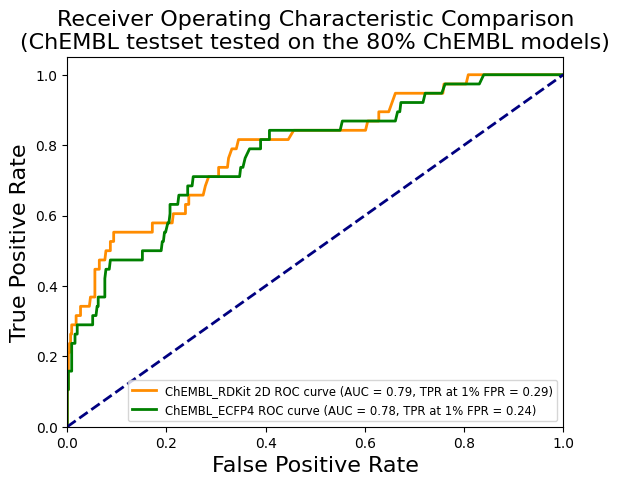

In [48]:
# Calculate TPR at 1% FPR for both models
tpr_at_1_fpr_model_1 = tpr_at_fpr(fpr_model_1, tpr_model_1)
tpr_at_1_fpr_model_2 = tpr_at_fpr(fpr_model_2, tpr_model_2)

# Update the labels to include the early ROC 1% value
label_model_1 = f'ChEMBL_RDKit 2D ROC curve (AUC = {roc_auc_model_1:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_1:.2f})'
label_model_2 = f'ChEMBL_ECFP4 ROC curve (AUC = {roc_auc_model_2:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_2:.2f})'

# Plot the ROC curves
plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, label=label_model_1)
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, label=label_model_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic Comparison\n(ChEMBL testset tested on the 80% ChEMBL models)', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.show()

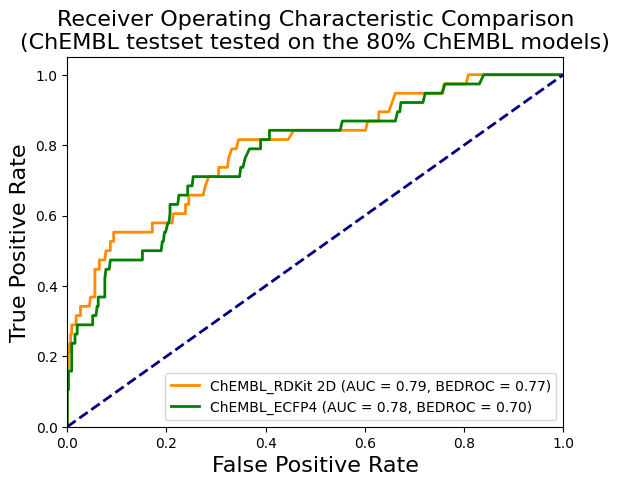

In [51]:
### bedroc version
bedroc_score_model_1 = bedroc_score1
bedroc_score_model_2 = bedroc_score2

plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, 
         label=f'ChEMBL_RDKit 2D (AUC = {roc_auc_model_1:.2f}, BEDROC = {bedroc_score_model_1:.2f})')
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, 
         label=f'ChEMBL_ECFP4 (AUC = {roc_auc_model_2:.2f}, BEDROC = {bedroc_score_model_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic Comparison\n(ChEMBL testset tested on the 80% ChEMBL models)', fontsize=16)
plt.legend(loc="lower right")
plt.show()

## test chembl models (smote) with pubchem dataset

In [76]:
# test the full set models with external test set (full set chembl)
model_3 = joblib.load('./pretrained_models/pubchem_morgan2_maxfeatures_sqrt_fullset.joblib')
model_2 = joblib.load('./pretrained_models/pubchem_rdkit2D_maxfeatures_sqrt_fullset.joblib')

In [68]:
chembl_testset1 = pd.read_csv('./datasets/3_train_test_split/chembl_testset_featurized.csv')
chembl_testset2 = pd.read_csv('./datasets/3_train_test_split/chembl_trainset_featurized.csv')

In [69]:
chembl_testset = pd.concat([chembl_testset1, chembl_testset2], ignore_index=True)

In [70]:
chembl_testset.loc[chembl_testset['activity_classification']== 'active', 'y_ture_lable'] = 1
chembl_testset.loc[chembl_testset['activity_classification']== 'inactive', 'y_ture_lable'] = 0

In [71]:
desc_cols4 = chembl_testset.iloc[:, 6:214]

### Ploting roc curves

In [78]:
X = np.array(desc_cols4)
y = chembl_testset.y_ture_lable

# Predict probabilities for the test data with Model 1
y_scores_model_1 = model_2.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_1, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score1 = CalcBEDROC(score, 1, 80.5)


# Compute ROC metrics for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y, y_scores_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

X = np.array(chembl_testset[morgan2_cols])
y = chembl_testset.y_ture_lable


# Predict probabilities for the test data with Model 2
y_scores_model_2 = model_3.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_2, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score2 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y, y_scores_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)

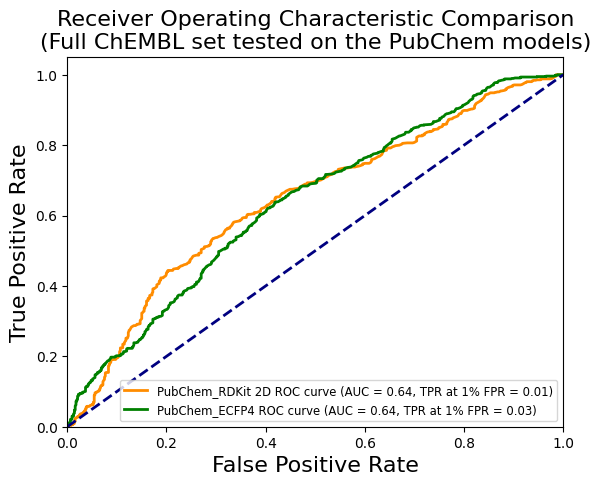

In [79]:
#early ROC version
# Calculate TPR at 1% FPR for both models
tpr_at_1_fpr_model_1 = tpr_at_fpr(fpr_model_1, tpr_model_1)
tpr_at_1_fpr_model_2 = tpr_at_fpr(fpr_model_2, tpr_model_2)
# Update the labels to include the early ROC 1% value
label_model_1 = f'PubChem_RDKit 2D ROC curve (AUC = {roc_auc_model_1:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_1:.2f})'
label_model_2 = f'PubChem_ECFP4 ROC curve (AUC = {roc_auc_model_2:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_2:.2f})'

# Plot the ROC curves
plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, label=label_model_1)
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, label=label_model_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic Comparison\n(Full ChEMBL set tested on the PubChem models)', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.show()

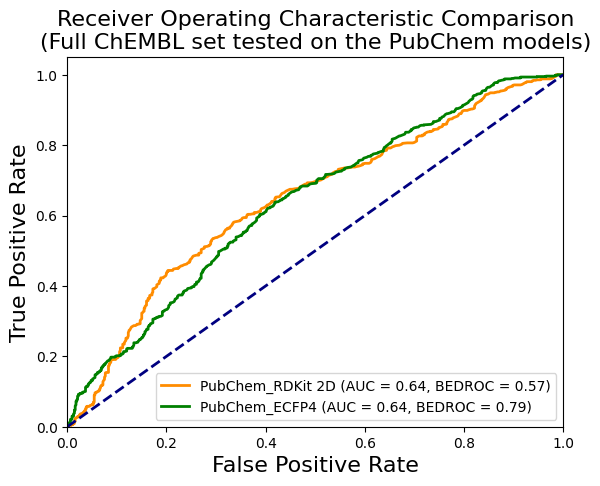

In [80]:
### bedroc version
bedroc_score_model_1 = bedroc_score1
bedroc_score_model_2 = bedroc_score2

plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, 
         label=f'PubChem_RDKit 2D (AUC = {roc_auc_model_1:.2f}, BEDROC = {bedroc_score_model_1:.2f})')
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, 
         label=f'PubChem_ECFP4 (AUC = {roc_auc_model_2:.2f}, BEDROC = {bedroc_score_model_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic Comparison\n(Full ChEMBL set tested on the PubChem models)', fontsize=16)
plt.legend(loc="lower right")
plt.show()